# Monte Carlo-simuleringer av polymerfolding

### Introduksjon
Vi har i dette prosjektet sett på polymerer, et polymer er satt sammen av monomerer. Vi har laget et program hvor man kan se på polymerer som er satt sammen av N antall monomerer. Ved å rotere polymerene rundt monomerer får polymerene nye egenskaper. Vekselvirkninger mellom monomerer kan oppstå under visse omstendigheter. Ved å bruke Monte Carlo-Simulering kan vi genere tilfeldig roterte polynomer med ulike egenskaper og energi. 


Koden i dette prosjektet inneholder mange større beregninger, noe som betyr at kjøretiden kan bli lang. Vi har derfor importert jit og njit fra numba for å kompliere koden og dermed minimere kjøretiden. I tillegg har vi også kun brukt numpy arrays, i stedet for vanlige python lister, da beregninger med numpy er mye raskere. 

In [3]:
import numpy as np
import numba as nb
from numba import njit, jit, int32 # njit: No-Python mode JIT (Just-In-Time compilation)
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

Spørsmål til m:
- Burde plottet av den første polymeren være på positiv eller negativ y-akse? (-polymer[:,0])

#### Representasjon av polymerene
Vi har valgt å representere hvert polymer som et N x 2 array. Polymeren er satt sammen av flere monomerer, der hvert element i polymer-arrayet er en monomer. Vi vil sentrere polymeren på mitten av korrdinatsystemet for at det skal ha et bedre utgangspunkt når det skal roteres. (Seinere bruker vi kooordinaten til elementet i polymer-arrayet til å representere polymeren og monomerene i et kartesisk koordinatsystem???). 

Det er også mulig å representere et polymer av lengden N i et array av dimensjon M x M, der M => N. De resterende plassene i M x M arrayet, som ikke illustrer en monomer, ville vært representert av nullere. Dette ville vært overflødig data som vi ikke trenger for å arbeide videre med polymeren. Ved å lagre masse nullere, som vi ikke er avhegning av for å løse oppgavene, vil koden bli betydelig treigere.

Dermed har vi valgt å jobbe med et N x 2 array for å unngå overflødig lagring av data, og oppnå raskest mulig kjøretid. 


(Finne ut hvor mye raskere/hvor mye midre tid dette tar).

In [4]:
N = 7  # Lengde på polymer
M = 9  # Gitterdimensjon

#Definerer først polymer som er et Nx2 array med datatype 32 bit
def init_polymer(N):
    polymer = np.zeros((N, 2), dtype=np.int32)
    polymer[:, 1] = np.arange(N) #np.arange(N)
    polymer[:, 0] = M // 2
    return polymer

init_polymer(N)

array([[4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4],
       [4, 5],
       [4, 6]], dtype=int32)

#### Endemonomerer
Når vi skal velge hvilket monomer som polymeret skal roteres rundt, så velges dette tilfeldig. Noe som er verdt å merke seg da er at dersom et polymer skal roteres om et endepunkt, så vil det ikke endre noe og polymeren vil forbli i ro. Dette er fordi vi med fordel har valgt at det alltid er den korte enden som skal roteres. Siden energien bestemmes av formen til polymeren, og den forblir uendret ved rotasjon om endemonomer, så vil energien også forbli uendret. Det vil altså hverken oppstå eller forsvinne noen vekselvirkninger mellom monomerer. Dette medfører at det vil være hensiksmessig å ikke inkludere endemonomerene i det tilfeldige utvalget monomeren trekkes fra. Vi vil derfor kun trekke fra 1 til N-1 i arrayet når vi skal velge hvilket monomer som skal roteres rundt. Dette vil være for å minimere kjøretiden til koden, siden den slipper å kjøre gjennom unødvendige steg. 

#### Illustrasjon av polymerene
For å illustrere polymerene, plotter vi monomerene som prikker bundet sammen av linjer som illustrer hele polymeren. Hvert monomer har sin egen farge og tall, dette gjør det enkelt å skille monomerene fra bakgrunnen, og se hvilke rekkefølge de har i polymeren. Polymeren vi starter med er illustrert som en rett linje, denne er sentrert i midten av koordinatsystemet så det blir enklere å arbeide med seinere når det skal roteres. 

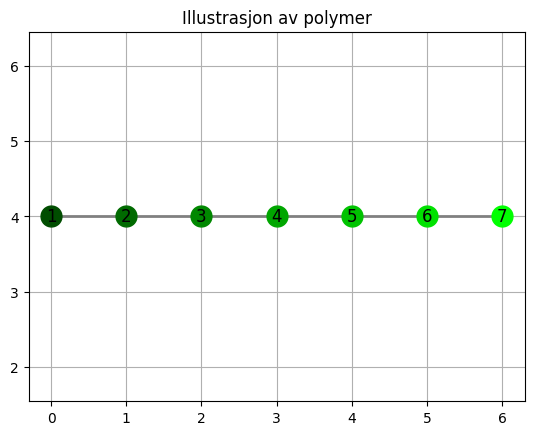

In [5]:
#d)
"""
def plot_polymer(polymer):
    plt.plot(polymer[:, 1], -polymer[:, 0], 'o-') # fortegn?? -polymer eller uten polymer
    plt.axis('equal')
    plt.show()
"""

def plot_polymer(polymer):
    
    # Assuming 'polymer' is an Nx2 numpy array
    plt.figure()
    num_points = polymer.shape[0]

    # Generating different shades of green
    greens = np.linspace(0.3, 1, num_points)  # Adjust the range for different shades
    colors = [(0, green, 0, 1) for green in greens]  # RGB tuples with varying green component

    # Plot the lines first
    plt.plot(polymer[:, 1], polymer[:, 0], 'o-', color='grey', markersize=10, linewidth=2)

    # Now plot each point and its number
    for i in range(num_points):
        # Plot each point with a different color
        plt.plot(polymer[i, 1], polymer[i, 0], 'o', color=colors[i], markersize=15)

        # Centering the number on the dot
        plt.text(polymer[i, 1], polymer[i, 0], str(i+1), color='black', fontsize=12, 
                 horizontalalignment='center', verticalalignment='center')

    plt.title("Illustrasjon av polymer")
    plt.axis('equal')
    plt.grid()
    plt.show()
    
plot_polymer(init_polymer(7))


#### Kreterium for polymerer
Vi har tatt utganspunkt at bindingene mellom monomerene i polymerene ikke skal kunne kan brytes, det skal heller ikke vøre mulig at to monomerer ender opp på samme plass. For at dette alltid skal stemme må vi kjøre polymerene gjennom en funskjone som sjekker om polymeret vi jobber med ikke er ødelagt polymer. Dette blir viktig seinere da vi skal rotere polymerer flere ganger, og vil stå igjen med et gyldig polymer.


Vi har tatt utgangspunkt i at polymerene er N x 2-arrays og at monomerene har hver sin koordinat i arrayet.

Det første kriteriumet vi må ta hensyn til er at det har N monomerer. Dette sjekker vi ved å returne FALSE dersom polymer-arrayet ikke har like mange elementer som lengden av arrayet. 

Det andre kriteriumet er at hver monomer representers av et unikt heltall. Vi sjekker dermed om polymerene har overlappende punkter.

I den første funksjonen vi lagde hadde vi et punkt som sjekket om monomeren nummer m var nærmeste nabo med nummer m-1 og m+1. Utifra modellen vi har tatt utganspunkt vil det ikke være mulig at monomerene i polymer arrayet endrer plass. Dermed vil den nye koden være mye mer tidseffektiv.


Forklare hva som kreves for at noe er et polymer, med monomerer(punkt1,2,3)
Forklare hvorfor den ene koden er raskerer enn den andre(når vi får til begge)

In [6]:
# e)

# @njit
def polymer_check_slow(polymer, N):
    if len(polymer) != N:
        return False
    for i in range(N):
        for j in range(N):
            if i != j:
                if polymer[i][0] == polymer[j][0] and polymer[i][1] == polymer[j][1]:
                    return False
    for i in range(N):
        if i == 0 or i == N-1:
            if not ((np.abs(polymer[i,0]-polymer[i+(-1 if i else 1),0]) == 1 and np.abs(polymer[i,1]-polymer[i+(-1 if i else 1),1]) == 0) or 
                    (np.abs(polymer[i,1]-polymer[i+(-1 if i else 1),1]) == 1 and np.abs(polymer[i,0]-polymer[i+(-1 if i else 1),0]) == 0)):
                return False
        else:
            if not ((np.abs(polymer[i,0]-polymer[i+1,0]) == 1 and np.abs(polymer[i,1]-polymer[i+1,1]) == 0) or
                    (np.abs(polymer[i,1]-polymer[i+1,1]) == 1 and np.abs(polymer[i,0]-polymer[i+1,0]) == 0) or
                    (np.abs(polymer[i,0]-polymer[i-1,0]) == 1 and np.abs(polymer[i,1]-polymer[i-1,1]) == 0) or
                    (np.abs(polymer[i,1]-polymer[i-1,1]) == 1 and np.abs(polymer[i,0]-polymer[i-1,0]) == 0)):
                return False
    return True

# Argumenter for at naboene vil alltid vere like. Ved induksjon vil dette holde for alle roteringer så lenge man starter med en gyldig polymer.

@njit
def polymer_check(polymer, N):

    # Sjekker om polymeren har riktig lengde
    if len(polymer) != N:
        return False
    
    # Sjekker om polymeren har overlappende punkter
    for i in range(N):
        for j in range(i + 1, N):
            if np.all(polymer[i] == polymer[j]):
                return False
            
    return True


#### Kodehastighet
Funksjonen polymer_check_slow bbruker (103 µs ± 4.86 µs), mens funksjonen polymer_check bruker (5.87 ns ± 196 ns). Vi ser at den andre koden er betydelig raskere enn den første. Dette er en stor fordel for resten av koden. 
Argumentere for at den ene er raskere.
Forklare hvorfor vi ikke sjekker punkt 3 i den raske?

In [7]:
%timeit polymer_check(init_polymer(7),7)
%timeit polymer_check_slow(init_polymer(7),7)

The slowest run took 6.07 times longer than the fastest. This could mean that an intermediate result is being cached.
12.6 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
98.3 µs ± 1.68 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Rotasjon av polymerer
For å rotere polymerene tar vi utganspunkt i matrisemultiplikasjon. Vi innfører to matriser, en som roterer 90 grader med klokken og en som roterer 90 grader mot klokken. Polymeren roteres om en valgt monomer, altså en koordinat i arrayet. Det er alltid den korteste siden av polymeret som skal roteres om monomeren, dermed må vi sjekke hvilke side som er kortest. Når vi har funnet korteste side kan vi multiplisere den korte delen av arrayet med rotasjonsmatrisen. Deretter kan vi sette den roterte delen av polymeren sammen med den lengre siden, og ender opp med et rotert polymer. 

In [8]:
CW_ROTATION_MATRIX = np.array([[0, -1], [1, 0]])
CCW_ROTATION_MATRIX = np.array([[0,1], [-1,0]])

#@njit
def twist_polymer(polymer: np.ndarray, monomer_idx: int, clockwise: bool) -> np.ndarray:
    """
    polymer: input polymer (N x 2)
    monomer_idx: index of monomer to twist
    clockwise: direction of twist
    """
    N = len(polymer)
    # Check which side is shorter
    shorter_side = monomer_idx < N - monomer_idx - 1 # True if shorter side is 0..=monomer_idx-1, False if shorter side is monomer_idx+1..=N-1

    # Slice array to get the smaller side
    if shorter_side:
        shorter_sub_polymer = polymer[:monomer_idx+1]
    else:
        shorter_sub_polymer = polymer[monomer_idx:]

    # Translate the shorter sub-polymer to origin at polymer[monomer_idx]
    center = polymer[monomer_idx]
    centered_sub_polymer = shorter_sub_polymer - center

    # Rotate the shorter sub-polymer by 90 degrees in the right direction (matrix multiplication with rotation matrix, follow `clockwise`)
    # Use the rotation matrices defined in constants above
    rotation_matrix = CW_ROTATION_MATRIX if clockwise else CCW_ROTATION_MATRIX
    rotated_sub_polymer = centered_sub_polymer @ rotation_matrix.T

    # Translate back to get final sub_polymer position
    twisted_sub_polymer = rotated_sub_polymer + center

    # Combine the two sub-polymers into a new polymer
    if shorter_side:
        twisted_polymer = np.concatenate((twisted_sub_polymer, polymer[monomer_idx+1:]), axis=0)
    else:
        twisted_polymer = np.concatenate((polymer[:monomer_idx], twisted_sub_polymer), axis=0)

    return twisted_polymer
    

#### Gyldige rotasjoner
Når det skal uitføres flere tilfeldige rotasjoner er det ikke sikkert at alle rotasjonene er gyldige. Dersom rotasjonen ikke hadde hatt noen betingelser kunne vi endt opp med en rotert polymer der to nabo monomerer endte på samme koordinat eller at polymeren mister bindingen mellom to monomerer. Vi har tatt utganspunkt i at bindingene mellom monomerene er så sterke at det ikke er godtatt at de brytes. 

Vi skal nå sjekke hvor mange gyldige rotasjoner vi får fra tiwst_polymer funksjonen. Dette gjør vi ved å bruke polymer_check funksjonen, og summerer opp antall gyldige polymerer. 


- g)
- i) plotte prosentandek gyldige rotasjoner


In [9]:
#Algoritme1
def random_rotations(polymer: np.ndarray, N_s: int) -> np.ndarray:
    """
    polymer: input polymer (N x 2)
    N_s: number of random rotation attempts
    """
    N = len(polymer)
    counter = 0  # TODO: Make sure this is correct -- ask TA
    current_polymer = polymer
    clockwise_draws = np.random.rand(N_s) < 0.5
    mon_idx_draws = np.random.randint(1, N - 1, size=N_s)  # Exclusive range [1, N-1), don't include end points
    for i in range(N_s):
        clockwise = clockwise_draws[i]
        mon_idx = mon_idx_draws[i]
        twisted_polymer = twist_polymer(polymer=current_polymer, monomer_idx=mon_idx, clockwise=clockwise)
        if polymer_check(twisted_polymer, len(twisted_polymer)):
                        counter +=1
                        current_polymer = twisted_polymer
    return current_polymer, counter

polymer4 = random_rotations(init_polymer(15), 4)[0]
polymer1000 = random_rotations(init_polymer(15), 1000)[0]

print("Polymer forsøkes rotert 4 ganger med", random_rotations(init_polymer(15), 4)[1] ,"gyldige rotasjoner.")
print("Polymer forsøkes rotert 1000 ganger med", random_rotations(init_polymer(15), 1000)[1] ,"gyldige rotasjoner.")


Polymer forsøkes rotert 4 ganger med 4 gyldige rotasjoner.
Polymer forsøkes rotert 1000 ganger med 579 gyldige rotasjoner.


### Kodehastighet random rotations
Tester random rotations funksjonene med to forskjellige versjoner av polymer check funksjonen.
Drøfte hvordan kjøretiden (med implementasjonen deres) skalerer med størrelsen på polymeren. 

In [10]:
# Tester random rotations funksjonen med polymwercheckslow
def random_rotations_slow(polymer: np.ndarray, N_s: int) -> np.ndarray:
    """
    polymer: input polymer (N x 2)
    N_s: number of random rotation attempts
    """
    N = len(polymer)
    counter = 0  # TODO: Make sure this is correct -- ask TA
    current_polymer = polymer
    clockwise_draws = np.random.rand(N_s) < 0.5
    mon_idx_draws = np.random.randint(1, N - 1, size=N_s)  # Exclusive range [1, N-1), don't include end points
    for i in range(N_s):
        clockwise = clockwise_draws[i]
        mon_idx = mon_idx_draws[i]
        twisted_polymer = twist_polymer(polymer=current_polymer, monomer_idx=mon_idx, clockwise=clockwise)
        if polymer_check_slow(twisted_polymer, len(twisted_polymer)):
                        counter +=1
                        current_polymer = twisted_polymer
    return current_polymer, counter

In [11]:

%timeit random_rotation_slow(init_polymer(15), 1000)
%timeit random_rotation_slow(init_polymer(30), 1000)

%timeit random_rotations(init_polymer(15), 1000)
%timeit random_rotations(init_polymer(30), 1000)


NameError: name 'random_rotation_slow' is not defined

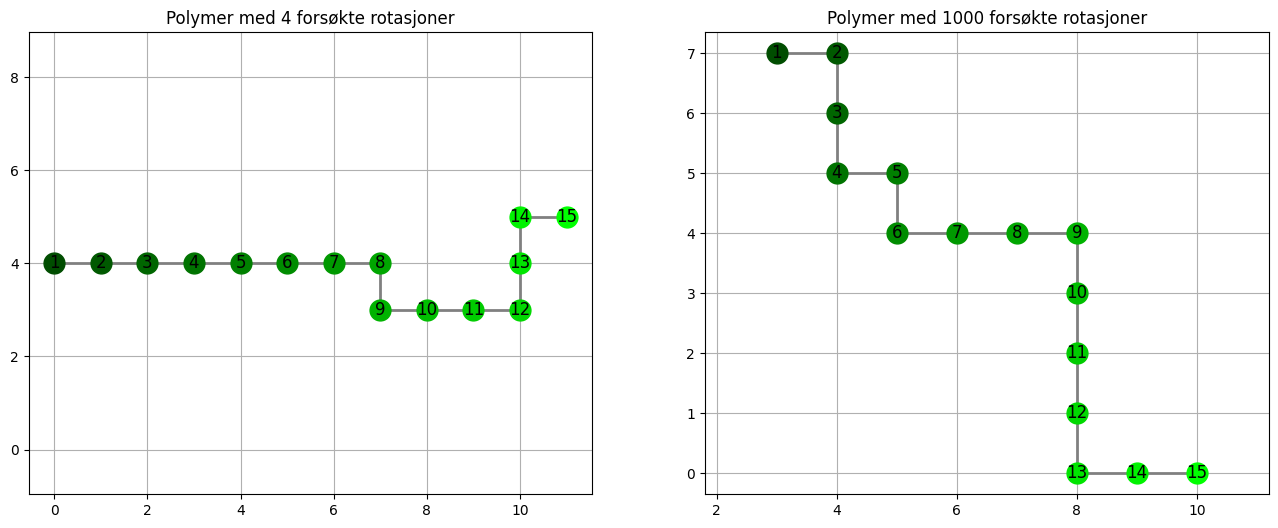

In [12]:
def plot_two_polymers(polymer1, polymer2, N_s1, N_s2, title1="", title2=""):
    # Assuming both 'polymer1' and 'polymer2' are Nx2 numpy arrays

    # Set up a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

    # Plot polymer1 in the first subplot
    num_points1 = polymer1.shape[0]
    colors = [(0, green, 0, 1) for green in np.linspace(0.3, 1, num_points1)]
    ax1.plot(polymer1[:, 1], polymer1[:, 0], 'o-', color='grey', markersize=10, linewidth=2)
    for i in range(num_points1):
        ax1.plot(polymer1[i, 1], polymer1[i, 0], 'o', color=colors[i], markersize=15)
        ax1.text(polymer1[i, 1], polymer1[i, 0], str(i+1), color='black', fontsize=12, 
                 horizontalalignment='center', verticalalignment='center')

    if title1 == "":
        ax1.set_title(f"Polymer med {N_s1} forsøkte rotasjoner")
    else:
        ax1.set_title(title1)
    
    ax1.axis('equal')
    ax1.grid()

    # Plot polymer2 in the second subplot
    num_points2 = polymer2.shape[0]
    ax2.plot(polymer2[:, 1], polymer2[:, 0], 'o-', color='grey', markersize=10, linewidth=2)
    for i in range(num_points2):
        ax2.plot(polymer2[i, 1], polymer2[i, 0], 'o', color=colors[i], markersize=15)
        ax2.text(polymer2[i, 1], polymer2[i, 0], str(i+1), color='black', fontsize=12, 
                 horizontalalignment='center', verticalalignment='center')

    if title2 == "":
        ax2.set_title(f"Polymer med {N_s2} forsøkte rotasjoner")
    else:
        ax2.set_title(title2)
    ax2.axis('equal')
    ax2.grid()

    plt.show()

plot_two_polymers(polymer4, polymer1000, 4, 1000)

#### Prosentandel gyldige rotasjoner
Bruk først N_s = 1000, diskuter hvordan N_s påvirker grafen. (inkluder gjerne flere grafer i figuren)

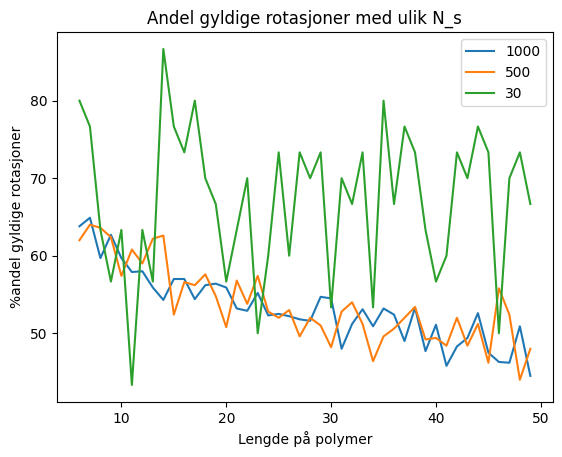

In [13]:
n = 50
N = np.arange(6,n)
y_vals_1000 = np.zeros(len(N))
y_vals_500 = np.zeros(len(N))
y_vals_30 = np.zeros(len(N))

for i in range(len(N)):
    y_vals_1000[i] = ((random_rotations(init_polymer(N[i]), 1000)[1])/1000)*100
    y_vals_500[i] = ((random_rotations(init_polymer(N[i]), 500)[1])/500)*100
    y_vals_30[i] = ((random_rotations(init_polymer(N[i]), 30)[1])/30)*100
   
plt.plot(N, y_vals_1000, label = "1000")
plt.plot(N, y_vals_500, label = "500")
plt.plot(N, y_vals_30, label = "30")
plt.legend()
plt.title("Andel gyldige rotasjoner med ulik N_s")
plt.xlabel("Lengde på polymer")
plt.ylabel("%andel gyldige rotasjoner")
plt.show()

#Lage regresjon av denne


#### Energi
Forklare V matrisen og operatoren b
E = 1/2 *sum(V*b)er

Hvilket polymer har lavest energi?
Polymeren med flest rotasjoner har størst energi. Polymeren med 4 rotasjoner rekker ikke å oppnå noe vekselvirkninger

In [14]:
#j)
@njit
def make_V_const(N, const_value):
    V = np.full((N, N), const_value)
    
    for i in range(N):
        for j in range(i-1, i+2):
            if 0 <= j < N:
                V[i, j] = 0       
    return V 


In [15]:
@njit
def nearest_neighbor(x0: int, y0: int, x1: int, y1: int) -> bool:
    return np.abs(x0 - x1) + np.abs(y0 - y1) == 1

@njit
def calculate_energy(twisted_polymer: np.ndarray, V: np.ndarray) -> float: 
    """
    twisted_polymer: input polymer (N x 2)
    V: interaction matrix (N x N)

    Assume that V[i, i+1] = V[i+1, i] = V[i, i] = 0 for all i
    """
    energy = 0
    N = twisted_polymer.shape[0]
    for i in range(N):
        for j in range(0, i - 1):
            mon1 = twisted_polymer[i]
            mon2 = twisted_polymer[j]
            if nearest_neighbor(mon1[0], mon1[1], mon2[0], mon2[1]):
                energy += V[i, j] + V[j, i]

    return energy / 2.0

print(calculate_energy(polymer4, make_V_const(15, -1)))
print(calculate_energy(polymer1000, make_V_const(15, -1)))


0.0
0.0


In [16]:
# 2a)
# Algoritme 2

def simulate_energy(polymer, N_s, V, T, max_iter=100_000):
    E_array = np.zeros(N_s)
    E = calculate_energy(polymer, V)
    beta = 1 / (1.38*10**(-23)*T) # Example calculation, adjust as needed

    i = 0
    while i < N_s:
    # for _ in trange(max_iter, desc="Simulating energy"):
        random_monomer = np.random.choice(len(polymer))  # Randomly choose a monomer
        twist_clockwise = np.random.choice([True, False])  # Randomly choose the twist direction

        twisted_polymer = twist_polymer(polymer, random_monomer, twist_clockwise)
        if polymer_check(twisted_polymer, len(twisted_polymer)):
            i += 1
            E_new = calculate_energy(twisted_polymer, V)
            if E_new < E or np.random.rand() < np.exp(-beta * (E_new - E)):
                polymer = twisted_polymer
                E = E_new
            E_array[i] = E
        if i >= N_s - 1:
            break

    return polymer, E_array

Temperatur har lite å si
Lengre polymer gir mer energi
Jo større polymerene jo større energiforskjeller(mer varierende energi)

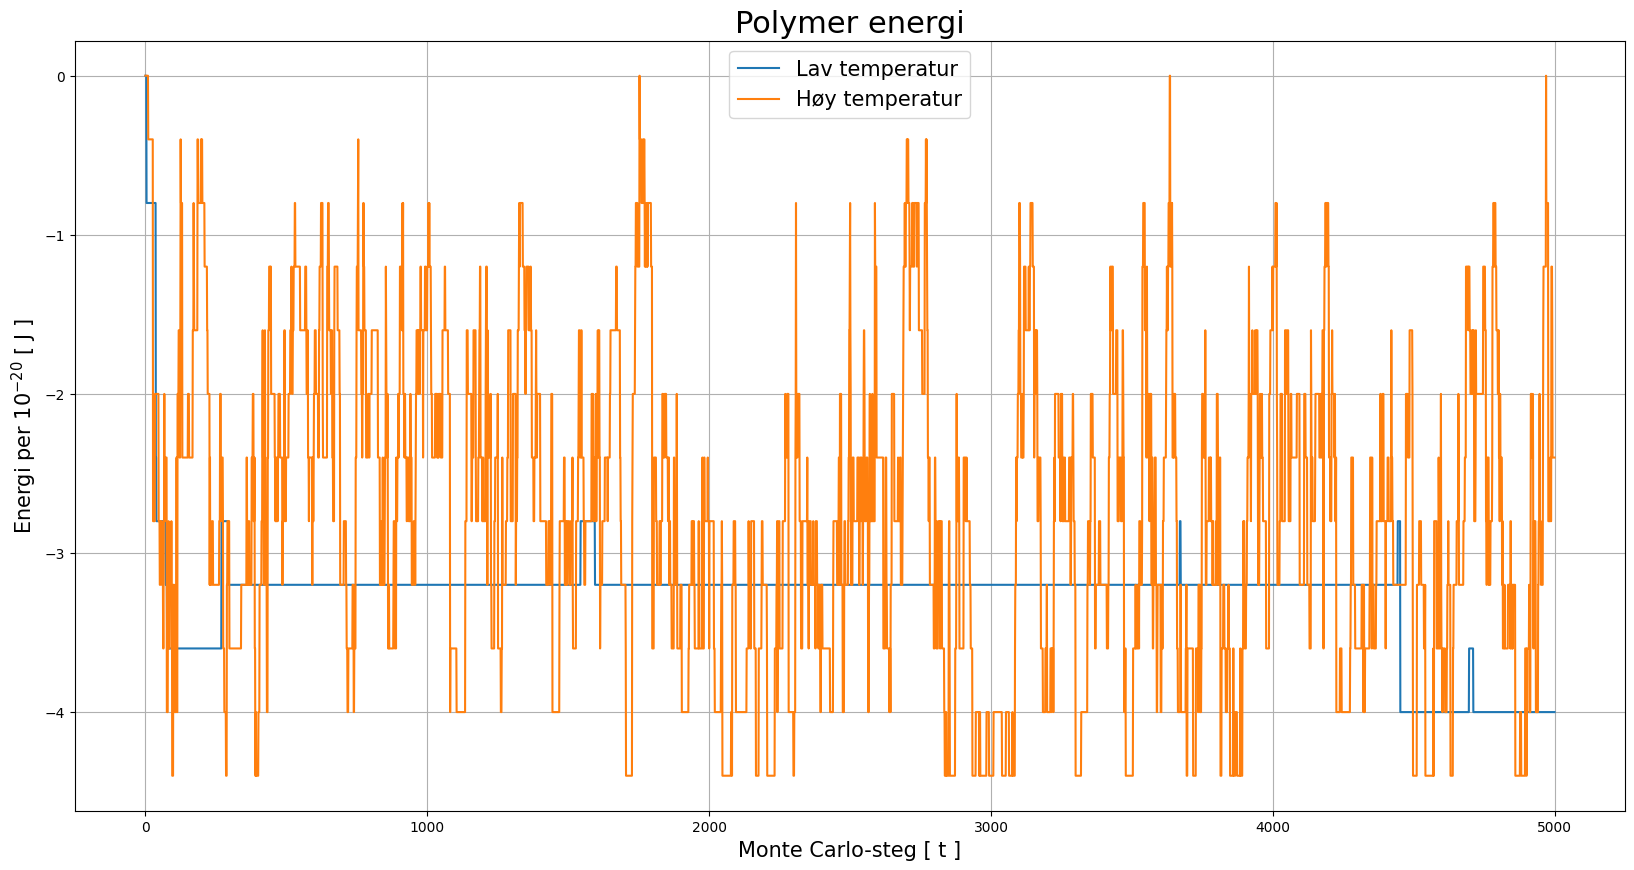

In [17]:
#2b)
t = 5000
T_low = 70
T_high = 350

V_1 = make_V_const(20, -4.0 * 10**(-21))
V_2 = make_V_const(20, -4.0 *10**(-21))

_polymer, energy_vals1 = simulate_energy(init_polymer(20), t, V_1, T_low) 
_polymer, energy_vals2 = simulate_energy(init_polymer(20), t, V_2, T_high) 


plt.title("Polymer energi", fontsize=22)
plt.xlabel("Monte Carlo-steg [ t ]", fontsize=15)
plt.ylabel("Energi per $10^{-20}$ [ J ]", fontsize=15) 
plt.grid()
plt.plot(np.arange(t), energy_vals1 * 10**20, label = "Lav temperatur")
plt.plot(np.arange(t), energy_vals2 * 10**20, label = "Høy temperatur")
plt.legend(fontsize=15)
plt.gcf().set_size_inches(20, 10)
plt.show()

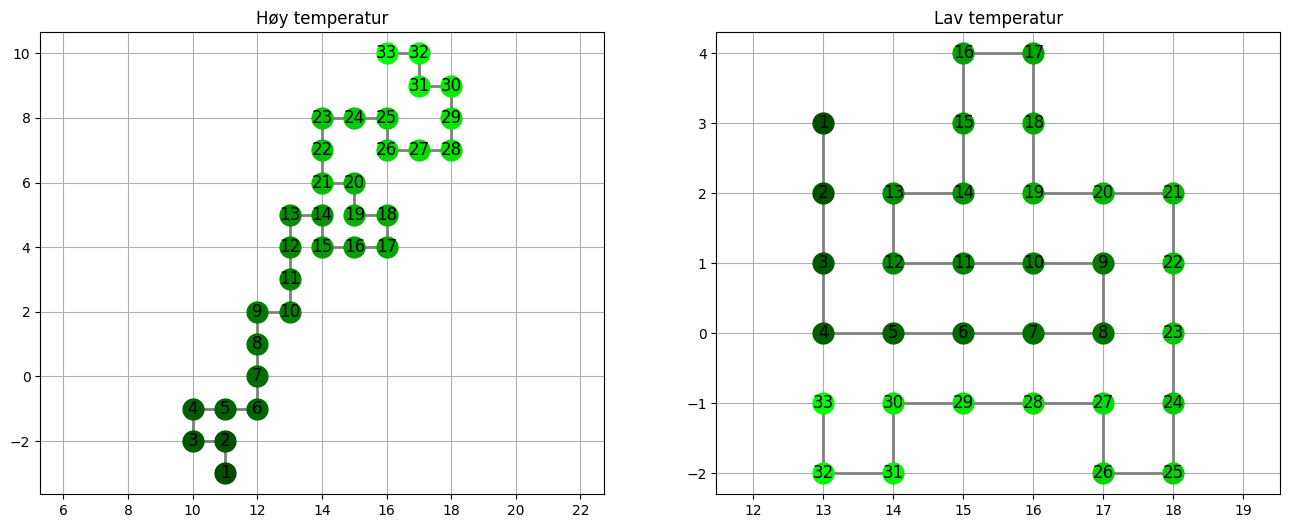

In [21]:
# 2c) Illustrer sluttposisjonen til de to polymerene fra simuleringen i 2b
polymer_high_temp = simulate_energy(init_polymer(33), t, V_1, T_high)[0]
polymer_low_temp = simulate_energy(init_polymer(33), t, V_1, T_low)[0]

plot_two_polymers(polymer_high_temp, polymer_low_temp, t, t, "Høy temperatur", "Lav temperatur")

#høy temp - ustabil energi, hopper rundt mellom energinivå
#lav temp - finner vanligvis lokalt minima, men ikke globalt minima. Vanskelig å hoppe ut av lokalt for å finne globalt.


[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1]
 [0 1 0 0 0 2 2 2 2 2]
 [0 1 1 0 0 0 2 2 2 2]
 [0 1 1 2 0 0 0 3 3 3]
 [0 1 1 2 2 0 0 0 3 3]
 [0 1 1 2 2 3 0 0 0 4]
 [0 1 1 2 2 3 3 0 0 0]
 [0 1 1 2 2 3 3 4 0 0]]


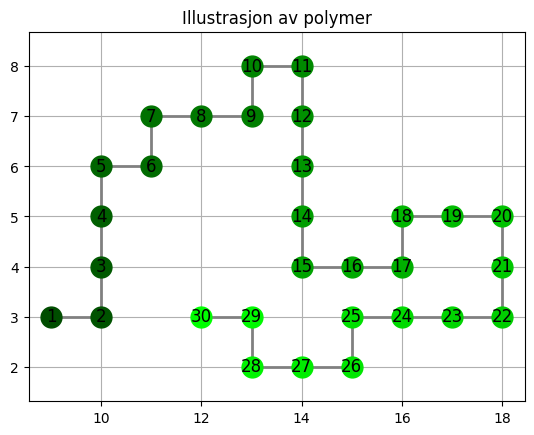

In [22]:
#2d) Symmetrisk matrise
@njit
def make_V(N, x):
    V = np.full((N, N), x)
    
    for i in range(N):
        for j in range(N):
            V[i,j] = (i+1)/x
    
    for i in range(N):
        for j in range(i-1, i+2):
            if 0 <= j < N:
                V[i, j] = 0   

    for i in range(N):
        for j in range(0, N):
            V[j, i] = V[i, j]    
    return V 


polymerV = simulate_energy(init_polymer(30),1000, make_V(10, 2),270)[0]
print(make_V(10,2))

plot_polymer(polymerV)

# høy verdi øverst høyre og lavest nederst venstre

Hvis energien blir mindre og mindre blir det flere rotasjoner
Hvis energien blir større og større blir det ferre rotasjoner
Hva er det som sier at matrisen V gir mye energi???

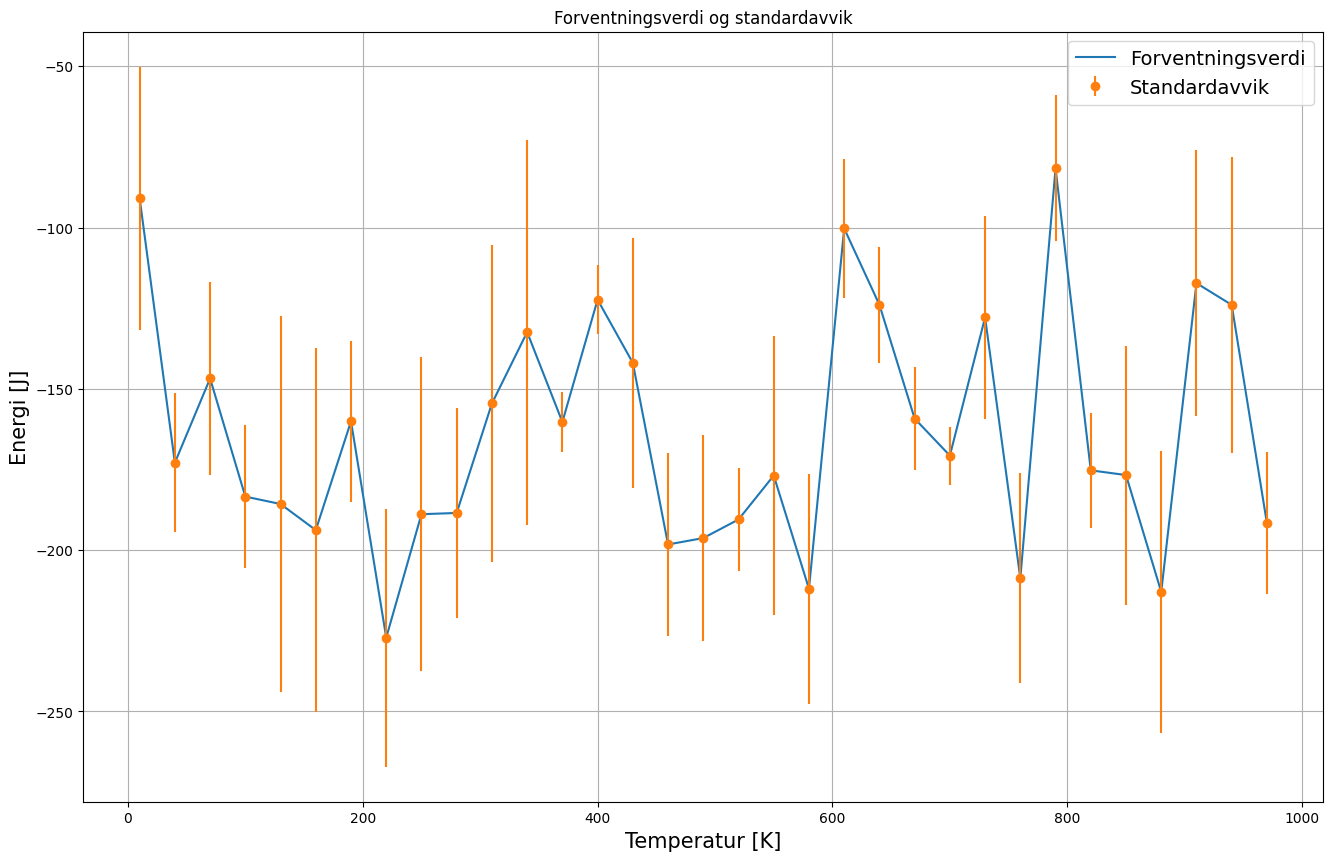

In [289]:
#2e)
#Beregne gjennomsnittsverdien av E som funksjon av T med standardavvik.

N = 30
N_s = 500
V = make_V_const(N, -1)
T = np.arange(10, 1000, 30)
E_array_mean = np.zeros(len(T))
E_array_sd = np.zeros(len(T))

for i in range(len(T)):
    E_array_mean[i] = np.mean(simulate_energy(init_polymer(N), N_s, V, T[i], max_iter=100_000)[1])
    E_array_sd[i] = np.std(simulate_energy(init_polymer(N), N_s, V, T[i], max_iter=100_000)[1])

plt.figure(figsize=(16,10))
plt.plot(T, E_array_mean, label="Forventningsverdi")
plt.errorbar(T, E_array_mean, yerr=E_array_sd, fmt='o', label="Standardavvik")
plt.legend(fontsize=14)
plt.title("Forventningsverdi og standardavvik")
plt.xlabel("Temperatur [K]", fontsize=15)
plt.ylabel("Energi [J]", fontsize=15)
plt.grid()
plt.show()
    
# Ask TA - skip 1000 steps? Is our graph correct?


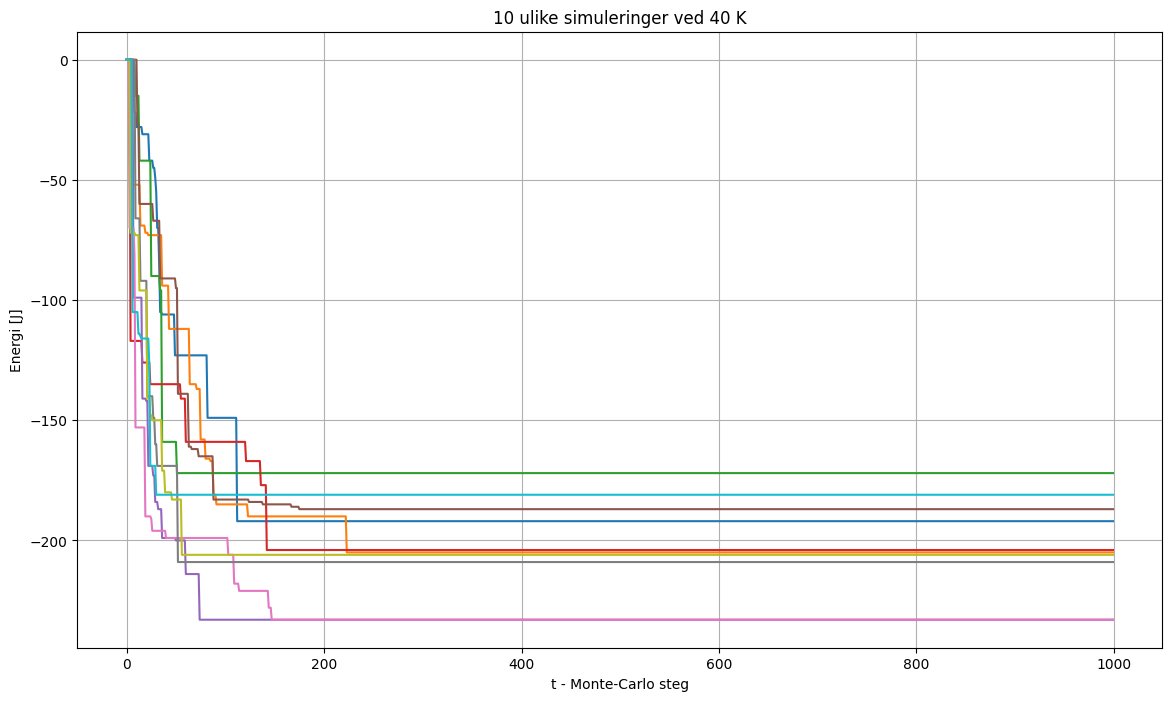

In [309]:
#2f)

# Ask TA - what is a good value for t? What are we supposed to se in the plots?

T = 40
t = 1000
x_vals = np.arange(t)
plt.figure(figsize=(14, 8))

for i in range(10):
    E_array = simulate_energy(init_polymer(N), t, V, T, max_iter=100_000)[1]
    plt.plot(x_vals, E_array)

plt.title(f"10 ulike simuleringer ved {T} K")
plt.xlabel("t - Monte-Carlo steg")
plt.ylabel("Energi [J]")
plt.grid()
plt.show()

In [332]:
def make_V_random(N):
    x = np.random.uniform(-6*10**(-21), -2*10**(-21))
    V = np.full((N, N),x)

    for i in range(N):
        for j in range(N):
                V[i, j] = np.random.uniform(-6*10**(-21), -2*10**(-21))

    for i in range(N):
        for j in range(i-1, i+2):
            if 0 <= j < N:
                V[i, j] = 0

    for i in range(N):
        for j in range(0, N):
            V[j, i] = V[i, j]

    return V

print(make_V_random(6))

[[ 0.00000000e+00  0.00000000e+00 -4.04223581e-21 -3.32581794e-21
  -4.29278155e-21 -2.11939970e-21]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.60157315e-21
  -3.87721358e-21 -3.16052291e-21]
 [-4.04223581e-21  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.15053964e-21 -3.92706062e-21]
 [-3.32581794e-21 -4.60157315e-21  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.57205575e-21]
 [-4.29278155e-21 -3.87721358e-21 -3.15053964e-21  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.11939970e-21 -3.16052291e-21 -3.92706062e-21 -3.57205575e-21
   0.00000000e+00  0.00000000e+00]]


In [377]:
def max_euclidean_distance(polymer: np.ndarray) -> float:
    
    # Calculate the squared distance between each pair of points
    # This avoids the need to compute square roots, which is computationally expensive
    squared_distances = np.sum((polymer[:, np.newaxis, :] - polymer[np.newaxis, :, :]) ** 2, axis=2)

    # Since the distance matrix is symmetric, we can focus only on the upper triangle (excluding the diagonal)
    max_distance_squared = np.max(squared_distances[np.triu_indices_from(squared_distances, k=1)])

    # Return the square root of the maximum squared distance
    return np.sqrt(max_distance_squared)


In [383]:
# Algoritme 2 med diameter
def simulate_energy_with_diameter(polymer, N_s, V, T, max_iter=100_000):
    E_array = np.zeros(N_s)
    d_array = np.zeros(N_s)
    E = calculate_energy(polymer, V)
    beta = 1 / (1.38*10**(-23)*T) # Example calculation, adjust as needed

    i = -1
    while i < N_s:
    # for _ in trange(max_iter, desc="Simulating energy"):
        random_monomer = np.random.choice(len(polymer))  # Randomly choose a monomer
        twist_clockwise = np.random.choice([True, False])  # Randomly choose the twist direction

        twisted_polymer = twist_polymer(polymer, random_monomer, twist_clockwise)
        if polymer_check(twisted_polymer, len(twisted_polymer)):
            i += 1
            E_new = calculate_energy(twisted_polymer, V)
            if E_new < E or np.random.rand() < np.exp(-beta * (E_new - E)):
                polymer = twisted_polymer
                E = E_new
            E_array[i] = E
            d_array[i] = max_euclidean_distance(polymer)
        if i >= N_s - 1:
            break

    return polymer, E_array, d_array

print(simulate_energy_with_diameter(init_polymer(15), 100, make_V_random(15),300)[2])

[12.16552506 11.40175425  9.21954446  9.21954446  9.21954446  6.40312424
  6.40312424  7.07106781  6.40312424  7.07106781  7.07106781  7.07106781
  6.32455532  6.32455532  8.60232527  8.24621125  6.32455532  6.32455532
  7.07106781  7.07106781  5.65685425  6.32455532  6.32455532  5.09901951
  6.70820393  6.70820393  6.70820393  6.70820393  6.70820393  6.70820393
  6.70820393  7.28010989  6.70820393  6.70820393  6.70820393  6.70820393
  6.70820393  8.06225775  8.06225775  8.06225775  8.06225775  8.06225775
  8.06225775  6.40312424  6.40312424  6.40312424  6.40312424  5.38516481
  5.38516481  5.38516481  5.38516481  5.38516481  5.38516481  5.38516481
  5.38516481  5.38516481  6.40312424  6.40312424  6.40312424  6.40312424
  6.40312424  6.40312424  6.40312424  6.40312424  6.40312424  5.09901951
  5.09901951  5.09901951  5.09901951  5.09901951  5.09901951  5.09901951
  5.09901951  5.09901951  5.09901951  5.09901951  5.09901951  5.09901951
  5.09901951  5.09901951  5.09901951  5.09901951  4

In [398]:
N = 30
N_s = 500
V = make_V_const(N, -1)
T = np.arange(10, 1000, 30)
d_array_mean = np.zeros(len(T))

for i in range(len(T)):
    d_array_mean[i] = np.mean(simulate_energy_with_diameter(init_polymer(N), N_s, V, T[i], max_iter=100_000)[2])


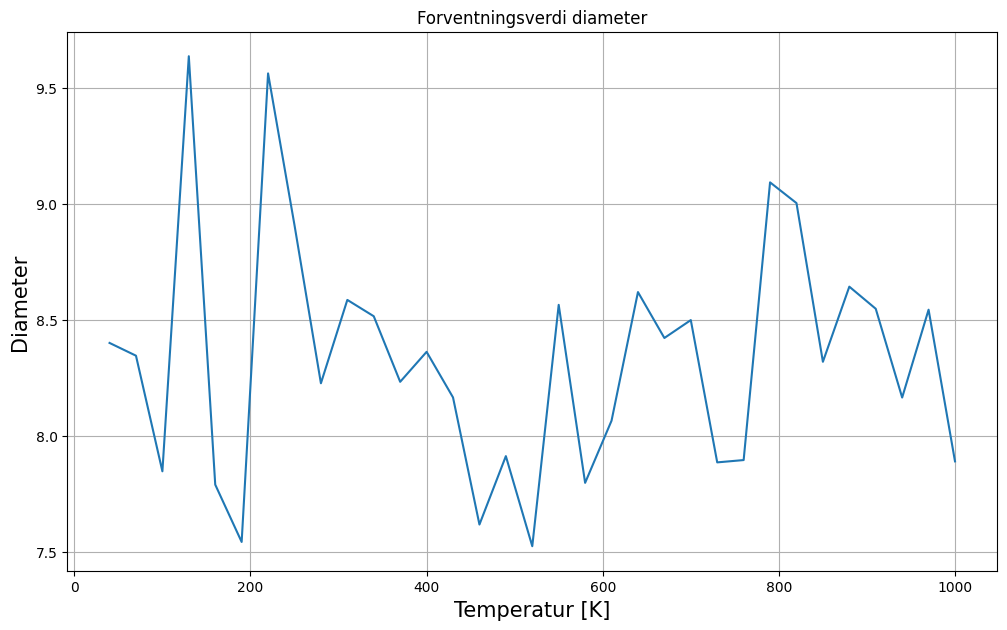

In [404]:
plt.figure(figsize=(12,7))
plt.plot(T, d_array_mean, label="Forventningsverdi")
plt.title("Forventningsverdi diameter")
plt.xlabel("Temperatur [K]", fontsize=15)
plt.ylabel("Diameter", fontsize=15)
plt.grid()
plt.show()

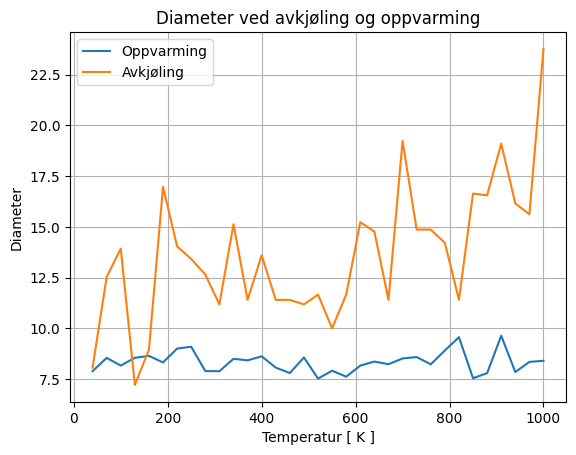

In [407]:
# Må finne riktig d_array her!
T = np.arange(1000, 10, -30)

d_array = np.zeros(len(T))
for i in range(len(T)):

    d_array[i] = simulate_energy_with_diameter(init_polymer(N), N_s, V, T[i], max_iter=100_000)[2][i]

plt.title("Diameter ved avkjøling og oppvarming")
plt.xlabel("Temperatur [ K ]")
plt.ylabel("Diameter")
plt.plot(T, d_array_mean[::-1], label = "Oppvarming")
plt.plot(T, d_array, label = "Avkjøling")
plt.legend(fontsize=10)
plt.grid()
plt.show()